# Maryland Inflation Forecasting  
**Data Preparation & Visualization**

In this notebook, we will set up the foundation for our time-series analysis and forecasting of Maryland’s quarterly inflation rate. Specifically, we will:

1. **Load & Inspect the Data**  
   – Import the raw CPI-based inflation series for Maryland  
   – Display summary statistics and check for missing values  

2. **Construct the Time-Series Index**  
   – Convert date columns to a `DatetimeIndex` at quarterly frequency  
   – Ensure proper ordering and continuity of the series  

3. **Visualize the Inflation Dynamics**  
   – Plot the raw inflation series over time  
   – Add rolling‐window statistics (mean, variance) to highlight trends and volatility  
   – Decompose into trend, seasonal, and residual components  


By the end of this notebook, we will have a clean, well-documented dataset, clear diagnostic plots, and all necessary transformations in place—paving the way for both classical ARIMA modeling and modern LSTM forecasting in subsequent sections. 

## Librarys 

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

## Full Data set 

In [6]:

Estados= pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\6 Semestre\\Econometria\\RawData.csv' , header= 0)
Estados

,state,year,quarter,pi_nt,pi_t,pi
0,Alabama,1989,1,3.605220,4.337426,3.984353
1,Alabama,1989,2,3.785178,5.133499,4.427839
2,Alabama,1989,3,4.118384,4.125880,4.173073
3,Alabama,1989,4,3.418778,3.440917,3.485882
4,Alabama,1990,1,2.821664,5.082320,3.865541
...,...,...,...,...,...,...
4694,Wisconsin,2016,4,0.918096,-1.442765,0.168776
4695,Wisconsin,2017,1,2.218032,0.329994,1.740557
4696,Wisconsin,2017,2,2.601992,0.969112,2.246920
4697,Wisconsin,2017,3,2.638051,1.608704,2.432090


## Missing Data 

In [7]:
for i in Estados.columns:
    if Estados[i].isna().sum() > 0:
        print('Datos Faltantes en {i}')
    else:
        pass 
else:
    print('No hay datos faltantes')    

No hay datos faltantes


## Select Maryland and create the quantiles 

In [8]:
Maryland = Estados.loc[Estados['state'] == 'Maryland']
Maryland['Trimestres'] = Maryland['year'].astype(str) + 'q' + Maryland['quarter'].astype(str)
Maryland

C:\Users\alejo\AppData\Local\Temp\ipykernel_17188\4109069357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Maryland['Trimestres'] = Maryland['year'].astype(str) + 'q' + Maryland['quarter'].astype(str)


,state,year,quarter,pi_nt,pi_t,pi,Trimestres
1876,Maryland,1978,1,-0.048849,-6.195058,-2.901486,1978q1
1877,Maryland,1978,2,-0.305623,-4.711444,-2.389739,1978q2
1878,Maryland,1978,3,1.024444,-1.964391,-0.422940,1978q3
1879,Maryland,1978,4,1.671797,1.989527,1.742279,1978q4
1880,Maryland,1979,1,2.779419,4.725660,3.577910,1979q1
...,...,...,...,...,...,...,...
2023,Maryland,2016,4,3.627616,-0.368572,2.520722,2016q4
2024,Maryland,2017,1,2.746223,0.586536,2.165246,2017q1
2025,Maryland,2017,2,2.936191,0.302614,2.185154,2017q2
2026,Maryland,2017,3,1.347940,0.795587,1.105632,2017q3


## Descriptive statistics

In [19]:
def medidas_tendencia(x):
    media = x.mean()
    mediana = x.median()
    mode_series = x.mode()
    if not mode_series.empty:
        moda = mode_series.iloc[0]
    else:
        moda = None
    df1 = pd.DataFrame({
        "Media": [round(media, 3)],
        "Mediana": [round(mediana, 3)],
        "Moda": [round(moda, 3)] if moda is not None else [None],
        'Datos en la moda': len(Maryland[x==moda])})

    df1.index = ['Inflacion']
    return df1

medidas_tendencia(Maryland['pi'])

,Media,Mediana,Moda,Datos en la moda
Inflacion,2.809,2.491,-2.901,1


- The **mean** inflation rate of 2.809 % slightly exceeds the **median** of 2.491 %, suggesting a right-skewed distribution driven by occasional high-inflation spikes.  
- The **mode** at –2.901 % occurs only once, indicating that extreme deflationary observations are rare but pull the average downward.  
- The gap between mean and median underscores moderate skewness, while the single occurrence of the modal value highlights the influence of outliers on Maryland’s inflation dynamics.  

In [15]:
def medidas_dispercion(x):
  varianza = x.var()
  sd1 = x.std()
  rango = x.max() - x.min()
  cv = (sd1 / x.mean()) * 100
  df = pd.DataFrame({
        "Varianza": [round(varianza, 3)],
        "Desviación Estándar": [round(sd1, 3)],
        "Rango": [round(rango, 3)] ,
        "Coeficiente de Variación": [round(cv , 3)] , 
        "Mínimo" : [round(x.min())] , 
        "Máximo":[round(x.max())]})
  
  df.index = ['Inflation']
    
  return df

medidas_dispercion(Maryland['pi'])

,Varianza,Desviación Estándar,Rango,Coeficiente de Variación,Mínimo,Máximo
Inflation,4.884,2.21,13.916,78.673,-3,11



- The **variance** of 4.884 and **standard deviation** of 2.21 indicate substantial fluctuation in quarterly inflation.  
- A **range** of 13.916 (from –3 % to 11 %) underscores the presence of both sharp deflationary episodes and steep inflationary spikes over the sample.  
- The high **coefficient of variation** (78.7 %) reflects that relative to its mean, inflation is quite volatile in Maryland’s history.  

# Graphs 

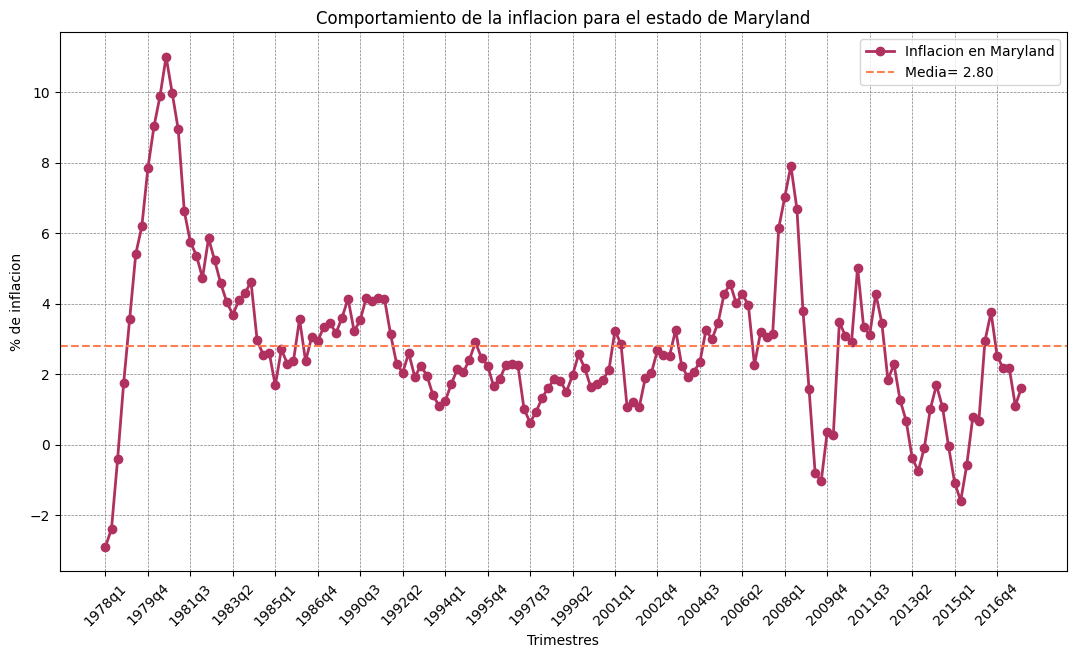

In [9]:

mean = Maryland['pi'].mean()

plt.figure(figsize=(13, 7))    
plt.plot(Maryland['Trimestres'], Maryland['pi'] ,label="Inflacion en Maryland", 
         linewidth=2 , color='#B03060', marker='o')
plt.axhline(mean, color='#FF7F50', linestyle='--', label='Media= 2.80 ')
cuartiles_a_mostrar = Maryland['Trimestres'][::7]
plt.xticks(cuartiles_a_mostrar, rotation=45)
plt.xlabel('Trimestres')
plt.ylabel('% de inflacion')
plt.title('Comportamiento de la inflacion para el estado de Maryland')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

The chart elegantly maps Maryland’s quarterly inflation from 1978 to 2016, oscillating around a 2.8 % long-term average; in the late 1980s, price growth skyrockets above 10 %, reflecting the Fed’s aggressive anti-inflation stance; through the 1990s, inflation settles into a tranquil 2 %–3 % corridor with steadily waning volatility; the 2008–2009 crisis then delivers a dramatic surge past 7 %, only to collapse into near-zero and occasional negative readings; in the subsequent recovery, inflation follows an unpredictable cadence of modest rebounds and subdued price pressures; from 2012 onward, intermittent deflationary quarters hint at fleeting downward shocks; by 2016, inflation peaks near 3 % before moderating to roughly 1 %–2 %; overall, this four-decade panorama interweaves shifts in monetary policy, business-cycle turns, and external shocks that together shape Maryland’s dynamic price landscape.  



C:\Users\alejo\AppData\Local\Temp\ipykernel_17188\3010100307.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Maryland.loc[:, 'fecha'] = pd.to_datetime(Maryland['Trimestres'])
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


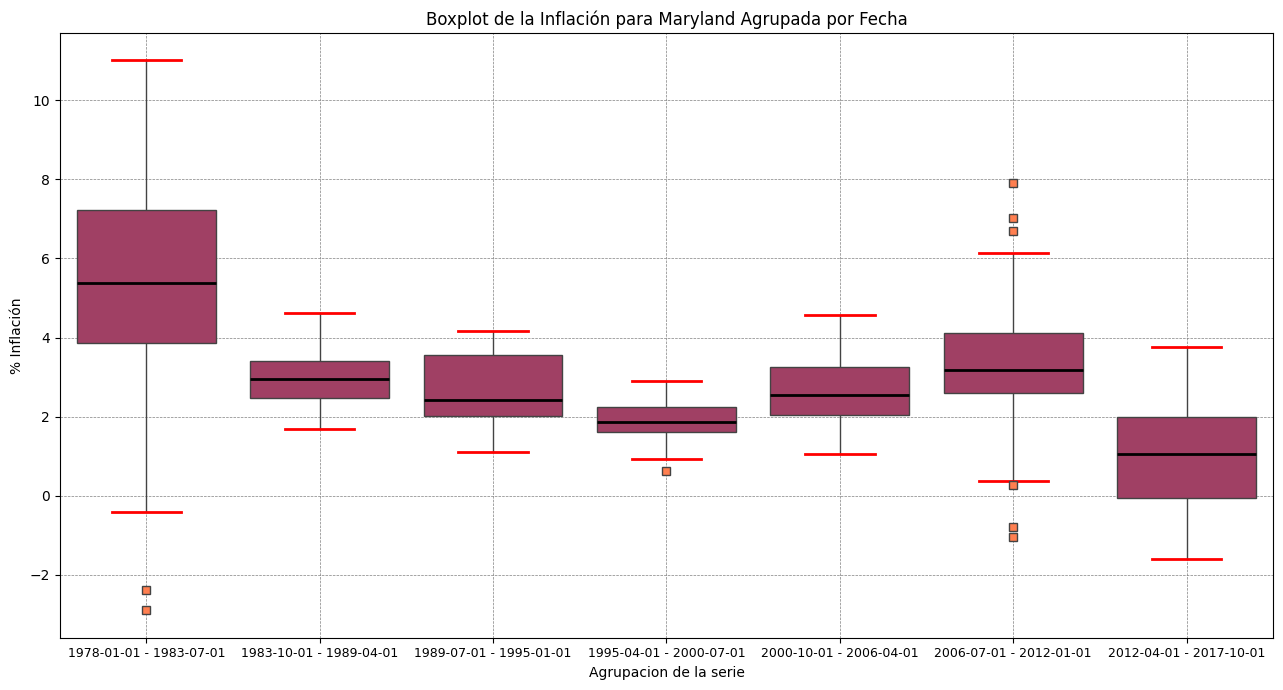

<Figure size 640x480 with 0 Axes>

In [13]:
Maryland = Maryland.copy()  


Maryland.loc[:, 'fecha'] = pd.to_datetime(Maryland['Trimestres'])
Maryland.loc[:, 'grupo_fecha'] = pd.cut(Maryland['fecha'], bins=7, labels=False)

grupo_limites = Maryland.groupby('grupo_fecha')['fecha'].agg(['min', 'max']).reset_index()
plt.figure(figsize=(13, 7))
sns.boxplot(x='grupo_fecha', y='pi', data=Maryland, color='#B03060' , capprops = dict(color = "red", linewidth = 2)
, flierprops = dict(marker = "s", markerfacecolor = '#FF7F50') , medianprops=dict(color='black', linewidth=2))
plt.xticks(ticks=range(len(grupo_limites)), labels=[f'{min_date.strftime("%Y-%m-%d")} - {max_date.strftime("%Y-%m-%d")}' for min_date, max_date in zip(grupo_limites['min'], grupo_limites['max'])])
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tick_params(axis='x', labelsize=9)
plt.xlabel('Agrupacion de la serie')
plt.ylabel('% Inflación')
plt.title('Boxplot de la Inflación para Maryland Agrupada por Fecha')
plt.tight_layout()
plt.show()
plt.savefig('Inflacion Boxplot maryland.png')

- **1978–1983:** The first period exhibits extreme volatility—median inflation near 5 %–6 %, whiskers stretching above 10 %, and outliers down to –3 %—reflecting the dramatic price swings of the late 1970s and early 1980s.  

- **1983–1989 & 1989–1995:** Both intervals show tighter interquartile ranges around 2.5 %–3.5 % with few outliers, indicating a sustained slowdown and stabilization of price growth through the mid-1990s.  

- **1995–2000 & 2000–2006:** Median inflation settles around 1.5 %–2.5 %, with narrower spreads and minimal extremes, suggesting continued low volatility during the economic expansion of the late 1990s and early 2000s.  

- **2006–2012:** Volatility resurfaces—median near 3 %, whiskers reaching almost 8 %, and occasional negative outliers—highlighting the impact of the 2008–09 financial crisis on Maryland’s inflation dynamics.  

- **2012–2017:** The final bin shows interquartile values between 0 %–2 % with both negative and positive outliers (–1.5 % to 3.5 %), capturing intermittent deflationary shocks and a modest rebound toward the end.  

- **Overall Pattern:** Across these seven bins, the boxplots chart four decades of shifting regimes—from high inflation and volatility in the 1980s, through relative calm in the 1990s and 2000s, to renewed turbulence around 2008, followed by a gradual return to muted price swings post-2012.  


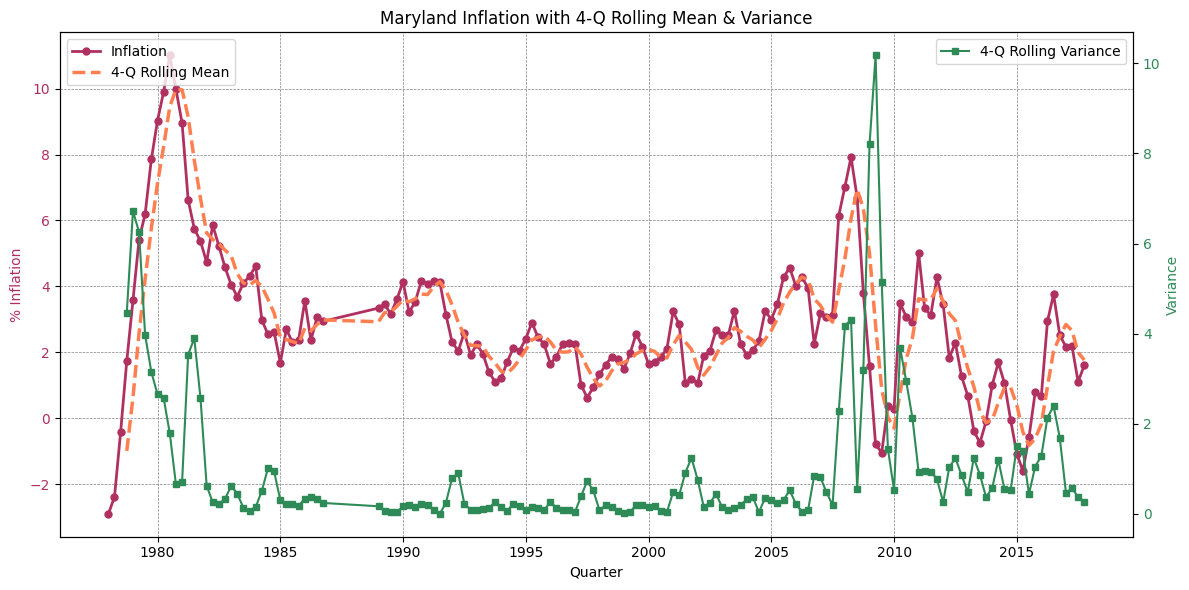

In [34]:
import matplotlib.pyplot as plt


window = 4 # Window size. 1 year 
Maryland['rolling_mean']= Maryland['pi'].rolling(window=window).mean()
Maryland['rolling_var']= Maryland['pi'].rolling(window=window).var()


fig, ax1 = plt.subplots(figsize=(12, 6))

# 1Raw inflation + rolling mean (left y-axis)
ax1.plot(Maryland['fecha'], Maryland['pi'], marker='o', lw=2, ms=5, color='#B03060', label='Inflation')
ax1.plot(Maryland['fecha'],  Maryland['rolling_mean'], ls='--', lw=2.5, color='#FF7F50', label=f'{window}-Q Rolling Mean')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('% Inflation', color='#B03060')
ax1.tick_params(axis='y', labelcolor='#B03060')
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_title('Maryland Inflation with 4-Q Rolling Mean & Variance')
ax1.legend(loc='upper left')

# Rolling variance (right y-axis)
ax2 = ax1.twinx()
ax2.plot(Maryland['fecha'], Maryland['rolling_var'], 
    ls='-', lw=1.5, color='#2E8B57', marker='s', ms=4, label=f'{window}-Q Rolling Variance')
ax2.set_ylabel('Variance', color='#2E8B57')
ax2.tick_params(axis='y', labelcolor='#2E8B57')
ax2.legend(loc='upper right')

fig.tight_layout()
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()


The time series plot juxtaposes Maryland’s raw quarterly inflation (solid maroon line), its 4-quarter rolling average (dashed orange line), and the corresponding rolling variance (green stepped line) to provide a multifaceted view of price dynamics. In the late 1970s and early 1980s, both inflation and its smoothed trend surge well above 8 %, underscoring the era’s elevated price pressures. Thereafter, the rolling mean stabilizes between roughly 2 % and 4 % from the mid-1980s through the early 2000s, reflecting a long spell of moderated growth and policy-driven stability. In contrast, the rolling variance line peaks sharply around 1980 and again during the 2008–2009 financial crisis, marking periods of heightened unpredictability linked to aggressive monetary tightening and systemic shocks. During calmer stretches—most notably the 1990s—the variance hovers near zero, confirming subdued volatility in inflation readings. Post-2010, the variance recedes to more moderate levels even as inflation continues to oscillate around 2 %–4 %, with sporadic dips below zero signalling short-lived deflationary episodes. Altogether, this integrated visualization highlights how spikes in volatility align with major economic disruptions, while the rolling average traces the gradual evolution of Maryland’s price environment over four decades.  


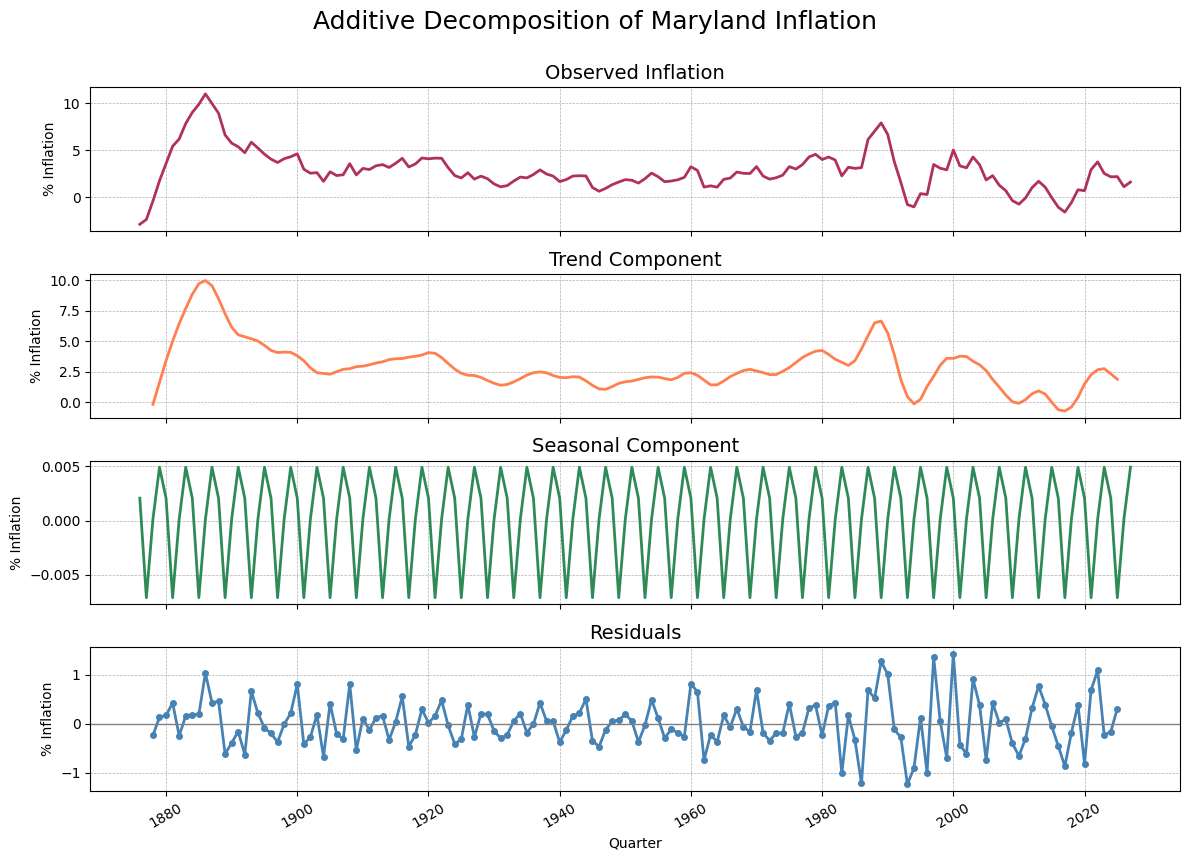

In [38]:


result = seasonal_decompose(Maryland['pi'], model='additive',period=4)           

fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Additive Decomposition of Maryland Inflation', fontsize=18, y=0.95)

axes[0].plot(Maryland.index, result.observed, color='#B03060', lw=2)
axes[0].set_title('Observed Inflation', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)

axes[1].plot(Maryland.index, result.trend, color='#FF7F50', lw=2)
axes[1].set_title('Trend Component', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)

axes[2].plot(Maryland.index, result.seasonal, color='#2E8B57', lw=2)
axes[2].set_title('Seasonal Component', fontsize=14)
axes[2].grid(True, linestyle='--', linewidth=0.5)

axes[3].plot(Maryland.index, result.resid, color='#4682B4', lw=2, marker='o', ms=4)
axes[3].axhline(0, color='gray', lw=1)
axes[3].set_title('Residuals', fontsize=14)
axes[3].grid(True, linestyle='--', linewidth=0.5)

for ax in axes:
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_ylabel('% Inflation')

axes[-1].set_xlabel('Quarter')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The additive decomposition neatly separates Maryland’s inflation series into three interpretable components:

1. **Trend:** The smoothed trend line captures the long‐run evolution of inflation. It rises sharply in the late 1970s, peaks around 1980, then gradually declines through the mid-1980s and stabilizes near 2–4 % until the mid-2000s. A pronounced spike reappears during the 2008–09 crisis, followed by a gradual moderation into the 2010s.

2. **Seasonal:** The seasonal component oscillates with a fixed quarterly pattern (period = 4), showing recurring peaks and troughs each year that average out to zero. Though its amplitude is small (± 0.005), it confirms a slight, consistent intra-year fluctuation in the inflation rate.

3. **Residual:** The remainder (actual minus trend and seasonal) exhibits scattered positive and negative shocks, without obvious pattern or autocorrelation. Most residuals lie within ± 0.5 %, indicating that the trend plus seasonal factors explain the bulk of inflation dynamics; occasional larger residuals correspond to outlying events like the 2008 financial crisis.

Overall, the decomposition demonstrates that Maryland’s inflation is driven primarily by its long-run trend—with modest, predictable seasonal swings—and that unexpected shocks (the residual) are relatively infrequent and small except during major economic upheavals.  


# **Made by Pablo Reyes** 
